In [1]:
train_dir = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets"
#test_dir = "/kaggle/input/files1/Malaria Cells/testing_set"
#val_dir = "/kaggle/input/dataset/val"

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.applications import ResNet152V2, DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, InputLayer, BatchNormalization, Flatten, Dense, Activation, MaxPool2D, AveragePooling2D, Conv2D, Reshape, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
#from keras_self_attention import SeqSelfAttention
from tensorflow.keras.activations import relu, softmax, sigmoid
from tensorflow.linalg import matrix_transpose
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

2024-08-06 16:14:01.540536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 16:14:01.540683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 16:14:01.688000: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [4]:
img_width, img_height = 224, 224
BATCH_SIZE_PER_REPLICA = 32
batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
epochs = 50
num_classes = 2

In [5]:
train_datagen = ImageDataGenerator( rescale=1./255, rotation_range=30, width_shift_range=0.25,
                                   height_shift_range=0.25, shear_range=0.25, zoom_range=0.25,
                                   horizontal_flip=True, fill_mode='nearest', validation_split=0.2)


test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(train_dir,target_size=(img_width, img_height),batch_size=batch_size, shuffle=True, class_mode='categorical', subset = 'training')

test_generator = test_datagen.flow_from_directory(train_dir,target_size=(img_width, img_height),batch_size=batch_size, class_mode='categorical',shuffle=False, subset = 'validation')

#val_generator = val_datagen.flow_from_directory( val_dir,
                                                  #target_size=(img_width, img_height),
                                                  #batch_size=batch_size, class_mode='categorical',
                                                  #shuffle=False )

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model

from tensorflow.keras.layers import *

In [7]:
def base_model(input_shape):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape, classes=1000)
    for layer in base_model.layers:
        layer._name = layer.name + str("_Densenet")
    return base_model


In [8]:
def base_model1(input_shape):
    base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, classes=1000)
    for layer in base_model1.layers:
        layer._name = layer.name + str("_ResNet50V2")
    return base_model1

In [9]:
def base_model2(input_shape):
    base_model2 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape, classes=1000)
    for layer in base_model2.layers:
        layer._name = layer.name + str("_MobileNetV2")
    return base_model2

In [10]:
def base_model3(input_shape):
    base_model3 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, classes=1000)
    for layer in base_model3.layers:
        layer._name = layer.name + str("InceptionV3")
    return base_model3

In [15]:
import tensorflow as tf
class SqrtLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SqrtLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.sqrt(inputs)

In [16]:
import tensorflow as tf

class RootCalculator(tf.keras.layers.Layer):
    def __init__(self, n, **kwargs):
        super(RootCalculator, self).__init__(**kwargs)
        self.n = n

    def call(self, inputs):
        return tf.math.pow(tf.convert_to_tensor(inputs, dtype=tf.float32), 1 / self.n)

    def compute_output_shape(self, input_shape):
        return input_shape


In [17]:
import tensorflow as tf

class SplitLayer(tf.keras.layers.Layer):
    def __init__(self, num_splits, **kwargs):
        super(SplitLayer, self).__init__(**kwargs)
        self.num_splits = num_splits

    def call(self, inputs):
        return tf.split(inputs, num_or_size_splits=self.num_splits, axis=-1)

    #def compute_output_shape(self, input_shape):
        #return [tf.TensorShape(input_shape[:-1].as_list() + [input_shape[-1] // self.num_splits])] * self.num_splits

    def get_config(self):
        config = super(SplitLayer, self).get_config()
        config.update({"num_splits": self.num_splits})
        return config




'input_shape = (32, 32, 64)\nnum_splits = 4\n\n# Create a model with the custom SplitLayer\ninputs = tf.keras.Input(shape=input_shape)\nsplits = SplitLayer(num_splits=num_splits)(inputs)\n\nmodel = tf.keras.Model(inputs=inputs, outputs=splits)\n\n# Print the model summary\nmodel.summary()\n\n# Create a dummy input tensor\ndummy_input = tf.random.normal((1,) + input_shape)\n\n# Get the output from the model\nsplit_outputs = model(dummy_input)\n\n# Print the shapes of the split outputs\nfor i, split_output in enumerate(split_outputs):\n    print(f"Shape of split {i}: {split_output.shape}")'

In [18]:
def convolution_block(input):
    x = Conv2D((input.shape[3]),(3,3),padding='same',activation=None)(input)
    x = BatchNormalization()(x)
    x = relu(x)
    return x

In [19]:
import tensorflow as tf

def residual_hierarchy_block(input):
    splits = SplitLayer(num_splits=2)(input)
    x1 = convolution_block(splits[1])
    y = splits[0] + x1
    return y

In [20]:
import tensorflow as tf

class TransposeLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        
        super(TransposeLayer, self).__init__(**kwargs)

    def call(self, inputs):
        
        return tf.transpose(inputs)

    def get_config(self):
        
        config = super(TransposeLayer, self).get_config()
        return config

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

        
class MatMulLayer(Layer):
    def __init__(self, **kwargs):
        super(MatMulLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Example TensorFlow operation: matrix multiplication
        x, y = inputs
        return tf.compat.v1.linalg.matmul(x, y)
    def compute_output_shape(self, input_shape):
        shape1, shape2 = input_shape
        return (shape1[0], shape1[1], shape2[2])



In [22]:
import tensorflow as tf



import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Define a custom layer
class CCA(Layer):
    def __init__(self, **kwargs):
        super(CCA, self).__init__(**kwargs)
        self.softmax = tf.nn.softmax

    def call(self, x):
        b, c, w, h = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        
        x1 = tf.reshape(x, (b, c, w * h))
        x1 = tf.transpose(x1, perm=[0, 2, 1])
        
        x2 = tf.reshape(x, (b, c, w * h))
        
        xres1 = tf.matmul(x2, x1)
        xres1 = self.softmax(xres1, axis=-1)
        
        xres2 = tf.matmul(xres1, x2)
        xres2 = tf.reshape(xres2, (b, c, w, h))
        
        xres2 = x + (xres2)
        
        return xres2

In [24]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0


input_shape=(224,224,3)
input_tensor = Input(shape=input_shape)

bm = base_model(input_shape)
bm_1 = base_model1(input_shape)
bm_2 = base_model2(input_shape)
bm_3 = base_model3(input_shape)

x = bm(input_tensor)
y = bm_1(input_tensor)
z = bm_2(input_tensor)
w = bm_3(input_tensor)

x = Conv2D(512, (1,1))(x)
y = Conv2D(512, (1,1))(y)
z = Conv2D(512, (1,1))(z)
w = Conv2D(512, (1,1))(w)



x1 = convolution_block(x)
x1 = CCA()(x1)
x1 = residual_hierarchy_block(x1)

y1 = convolution_block(y)
y1 = CCA()(y1)
y1 = residual_hierarchy_block(y1)

z1 = convolution_block(z)
z1 = CCA()(z1)
z1 = residual_hierarchy_block(z1)

w1 = convolution_block(w)
w1 = CCA()(w1)
w1 = residual_hierarchy_block(w1)

x = GlobalAveragePooling2D()(x1)
y = GlobalAveragePooling2D()(y1)
z = GlobalAveragePooling2D()(z1)
w = GlobalAveragePooling2D()(w1)
print(x.shape)
print(y.shape)
print(z.shape)
print(w.shape)


x1 = Dense(2,activation = 'sigmoid',kernel_initializer='he_normal',use_bias=True,bias_initializer='zeros')(x)
y1 = Dense(2,activation = 'sigmoid',kernel_initializer='he_normal',use_bias=True,bias_initializer='zeros')(y)
z1 = Dense(2,activation = 'sigmoid',kernel_initializer='he_normal',use_bias=True,bias_initializer='zeros')(z)
w1 = Dense(2,activation = 'sigmoid',kernel_initializer='he_normal',use_bias=True,bias_initializer='zeros')(w)

x2 = (y1*y1) + (z1*z1) + (w1*w1)
y2 = (x1*x1) + (z1*z1) + (w1*w1)
z2 = (x1*x1) + (y1*y1) + (w1*w1)
w2 = (x1*x1) + (y1*y1) + (z1*z1)

x3 = (x2*0.33) * (x1)
y3 = (y2*0.33) * (y1)
z3 = (z2*0.33) * (z1)
w3 = (w2*0.33) * (w1)

k = (x3 + y3 + z3 + w3)*0.25

#k = ((x1*x1) + (y1*y1) + (z1*z1))/2

k =  RootCalculator(4)(k)

model = tf.keras.Model(inputs=input_tensor, outputs=k)


model.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy',metrics=['accuracy','mse'])

#model.summary()




83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(None, 256)
(None, 256)
(None, 256)
(None, 256)


In [25]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [26]:
#tf.config.experimental_run_functions_eagerly(True)


In [27]:
for layer in model.layers:
    layer.trainable = True

In [28]:

checkpoint = ModelCheckpoint('oral_cancer.weights.h5', monitor='val_accuracy',
                              save_best_only = True, save_weights_only = True, mode ='max', verbose = 2)

early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max', verbose = 2)

reduce_learning_rate=ReduceLROnPlateau(monitor = "val_accuracy", factor = 0.1, patience = 4, verbose = 2)

In [29]:
import time
start_time = time.time()

history=model.fit(train_generator, epochs = 6, validation_data = test_generator,callbacks = [checkpoint,early_stop,reduce_learning_rate])

end_time = time.time()
preprocessing_time = end_time - start_time

print("Preprocessing completed. Time taken:", preprocessing_time, "seconds")

Epoch 1/6


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-06 16:29:06.509513: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_238093__.159483] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-08-06 16:30:05.200098: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m58.69070747s

********************************
[Compiling module a_inference_one_step_on_data_238093__.159483] Very slow compile? If you want to file a bug, run with envvar XLA_F

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.9724 - loss: 0.0683 - mse: 0.0258
Epoch 1: val_accuracy improved from -inf to 0.99950, saving model to oral_cancer.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1250s 1s/step - accuracy: 0.9725 - loss: 0.0681 - mse: 0.0257 - val_accuracy: 0.9995 - val_loss: 0.1473 - val_mse: 0.0562 - learning_rate: 1.0000e-04
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.9955 - loss: 0.0142 - mse: 0.0192
Epoch 2: val_accuracy did not improve from 0.99950
250/250 ━━━━━━━━━━━━━━━━━━━━ 221s 865ms/step - accuracy: 0.9955 - loss: 0.0142 - mse: 0.0192 - val_accuracy: 0.9520 - val_loss: 0.3657 - val_mse: 0.1351 - learning_rate: 1.0000e-04
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.9977 - loss: 0.0077 - mse: 0.0241
Epoch 3: val_accuracy did not improve from 0.99950
250/250 ━━━━━━━━━━━━━━━━━━━━ 221s 866ms/step - accuracy: 0.9977 - loss: 0.0077 - mse: 0.0241 - val_accuracy: 0.9950 - val_loss: 0.0663 - val_mse: 0.0353 

In [30]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

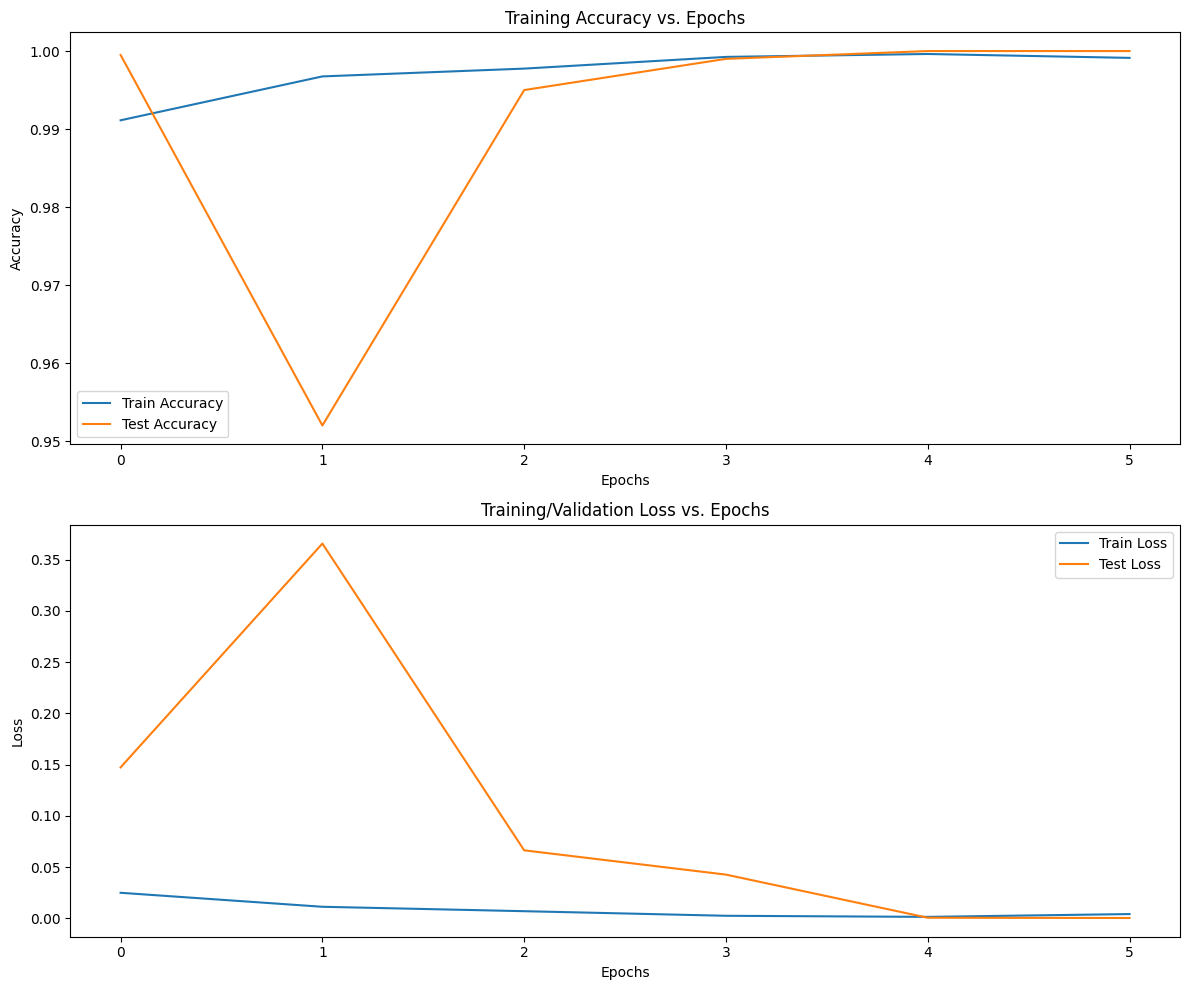

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy,label='Train Accuracy')
ax[0].plot(val_accuracy,label='Test Accuracy')
ax[0].set_xlabel('Epochs')

ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss,label='Train Loss')
ax[1].plot(val_loss,label='Test Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [32]:
train_class_names = sorted(list(train_generator.class_indices.keys()))

test_class_names = sorted(list(test_generator.class_indices.keys()))

assert train_class_names == test_class_names, "Class names in train and test datasets don't match!"

labels = train_class_names

In [33]:
# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
true_labels = test_generator.classes

# Generate predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Define class labels (replace with your actual class names)
labels = train_class_names  # Replace with your class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

63/63 ━━━━━━━━━━━━━━━━━━━━ 88s 800ms/step


In [34]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1000    0]
 [   0 1000]]


In [35]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [36]:
# Extracting metrics using classification_report
metrics = classification_report(true_labels, predicted_labels, output_dict=True)

In [37]:
# Calculate average metrics for all classes
avg_precision = metrics['macro avg']['precision']
avg_recall = metrics['macro avg']['recall']
avg_f1_score = metrics['macro avg']['f1-score']

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1-Score:", avg_f1_score)

Average Precision: 1.0
Average Recall: 1.0
Average F1-Score: 1.0


In [38]:
def print_model_layer_names(model):
    for layer in model.layers:
        print(layer.name)

# Assuming 'model1' is your model
print_model_layer_names(model)

input_layer
resnet50
densenet169
xception
conv2d_5
conv2d_6
efficientnetb0
conv2d_4
conv2d_10
conv2d_12
conv2d_7
conv2d_8
batch_normalization_6
batch_normalization_8
conv2d_14
batch_normalization_4
batch_normalization_10
spectral_attention_1
spectral_attention_2
spectral_attention
split_layer_1
split_layer_2
spectral_attention_3
split_layer
conv2d_11
conv2d_13
split_layer_3
conv2d_9
batch_normalization_7
batch_normalization_9
conv2d_15
batch_normalization_5
batch_normalization_11
global_average_pooling2d_1
global_average_pooling2d_2
global_average_pooling2d
dense_1
dense_2
global_average_pooling2d_3
dense
dense_3
root_calculator


In [39]:
# Get the names of all layers in the model
layer_names = [layer.name for layer in model.layers]

# Find the last convolutional layer
last_conv_layer_name = None
for layer_name in reversed(layer_names):
    if 'conv' in layer_name:
        last_conv_layer_name = layer_name
        break

# Verify if a convolutional layer is found
if last_conv_layer_name:
    print("Last convolutional layer name:", last_conv_layer_name)
else:
    print("No convolutional layer found in the model.")


Last convolutional layer name: conv2d_15


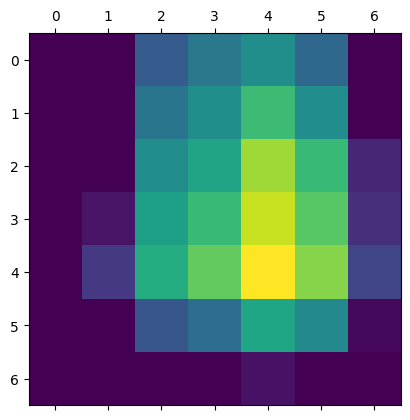

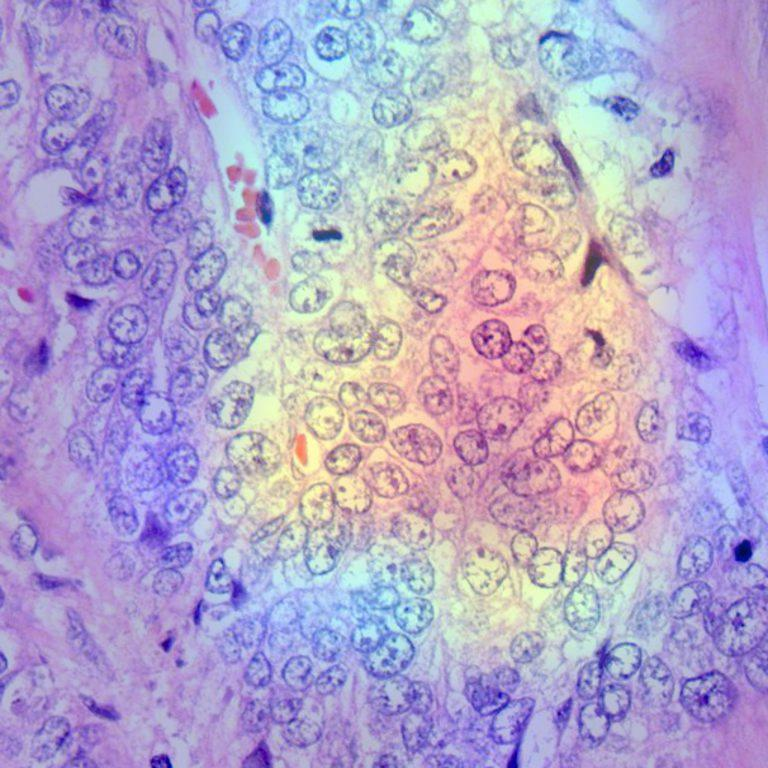

In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from IPython.display import Image, display

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.nan_to_num(heatmap, nan=0.0, posinf=1.0, neginf=0.0)
    heatmap = np.uint8(255 * heatmap)

    jet = plt.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))

# Define the parameters
img_path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/colonca1.jpeg'
last_conv_layer_name = "spectral_attention_1"
img_size = (224, 224)

# Load the DenseNet201 model with pre-trained weights
#model = DenseNet201(weights='imagenet', include_top=True)

# Prepare image
img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Remove last layer's softmax
model.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Save and display Grad CAM
save_and_display_gradcam(img_path, heatmap)